# State Farm Distracted Driver Competition

- Training: List of images of distracted drivers along with what distracts them.
- Test: Given a list of images identify what distracts the drivers.

## Imports and Data Loading

In [18]:
from fastai.vision import *
import pandas as pd

In [19]:
np.random.seed(62)

In [2]:
imgs = Path('/home/jupyter/state-farm-distracted-driver-detection/imgs')

In [13]:
train_path = imgs/'train'
test_path = imgs/'test'

In [5]:
dbunch = ImageDataBunch.from_folder(
    train_path, # folder that contains the data
    train=".", # relative location of the folder of the training set
    valid_pct=0.2, # Percentage of validation set
    ds_tfms=get_transforms(), # transformations - use default
    size=224, # size of images
    num_workers=8 # number of cpu workers
).normalize(imagenet_stats) # normalize via imagenet stats

In [6]:
dbunch.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

The 10 classes correspond to:

- *c0*: safe driving
- *c1*: texting - right
- *c2*: talking on the phone - right
- *c3*: texting - left
- *c4*: talking on the phone - left
- *c5*: operating the radio
- *c6*: drinking
- *c7*: reaching behind
- *c8*: hair and makeup
- *c9*: talking to passenger


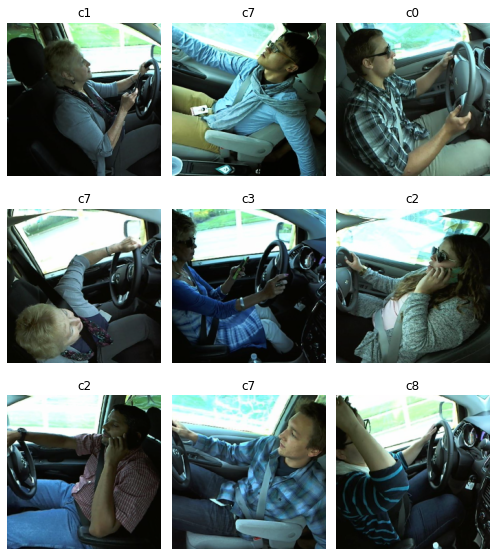

In [7]:
dbunch.show_batch(rows=3, figsize=(7,8))

## Modeling & Training

Use a Convolutional Neural Network and transfer learning from the pretrained model resnet50 which was trained on imagenet.

In [16]:
learn = cnn_learner(dbunch, models.resnet50, metrics=[error_rate])

Plot learning rates along with the error they produce.

epoch,train_loss,valid_loss,error_rate,log_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


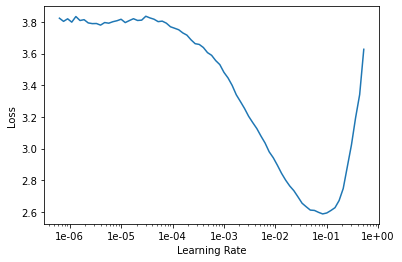

In [12]:
learn.lr_find()
learn.recorder.plot()

Training time!

- Train only the last layer of the CNN (because the rest of the model is already pretrained).

- Train for 4 epochs (= passes of the training set) using a learning rate of `2e-2`.

- Chose this learning rate by finding a steep slope near the global minimum.

In [17]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.681105,0.732354,0.177520,02:33
1,0.321627,0.751220,0.206512,02:29
2,0.167388,0.076064,0.022971,02:31
3,0.083096,0.063104,0.017395,02:29


1.7% error with just ~10 minutes of training!!

Save our model parameters to avoid retraining in the future (a costly operation!).

In [20]:
learn.save('resnet50-stage-1')

In [21]:
learn.load('resnet50-stage-1');

Unfreeze the model to train all layers of the CNN.

This allows earlier parameters to become more specific to our training set.

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


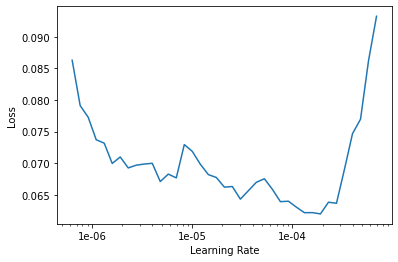

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.068617,0.053479,0.012489,03:20
1,0.052006,0.048477,0.012043,03:19


We were able to get the loss down to 1.2%!

In [25]:
learn.save('resnet50-stage-2')

In [ ]:
learn.load('resnet50-stage-2');

## Interpretation of failed cases

Let's interpret our results learning model to find out where the 1.2% error comes from.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

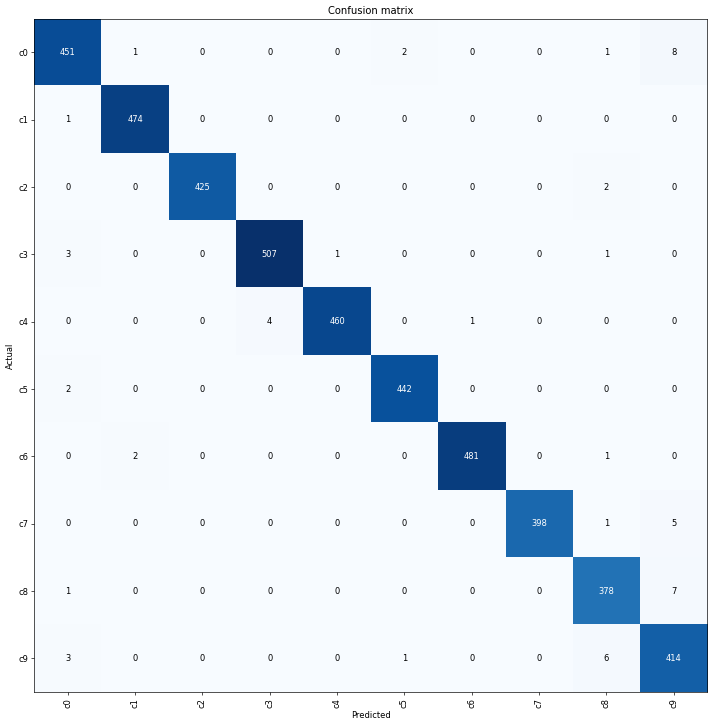

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

- Talking to a passenger is sometimes confused to being focused.
- Hair and makeup is sometimes confused to talking with a passenger.

## Test Set Predictions

Get predictions to submit.

In [31]:
dbunch.add_test(ImageList.from_folder(test_path))

In [34]:
learner = cnn_learner(dbunch, models.resnet50)
learner.load('resnet50-stage-2');

In [35]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
submission = pd.DataFrame({'img': os.listdir(imgs/'test'),
                          'c0': preds[:,0],
                          'c1': preds[:,1],
                          'c2': preds[:,2],
                          'c3': preds[:,3],
                          'c4': preds[:,4],
                          'c5': preds[:,5],
                          'c6': preds[:,6],
                          'c7': preds[:,7],
                          'c8': preds[:,8],
                          'c9': preds[:,9]})

In [37]:
submission.to_csv('/home/jupyter/distracted-driving.csv', index=False)

Submission got a score that would've putted it in the 219 place out of 1438 contestants -> 15% of best submissions.